## Regularization:

it is to overcome overfitting that is a common problem in neural networks

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_moons, make_circles, make_classification
import scipy.io
from init_utils import sigmoid, relu, plot_decision_boundary, predict_dec
from init_utils import compute_loss, predict, forward_propagation, backward_propagation, update_parameters


%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [73]:
def load_2D_dataset(seed=3):
    """
    Generates a 2D dataset for binary classification.
    Returns train and test sets: train_X, train_Y, test_X, test_Y
    """
    np.random.seed(seed)
    
    # Generate 2D data: X shape (2, number of examples), Y shape (1, number of examples)
    X, Y = make_moons(n_samples=400, noise=0.2, random_state=seed)
    
    # Transpose to match expected shapes
    X = X.T
    Y = Y.reshape(1, Y.shape[0])
    
    # Split into train and test sets
    train_X = X[:, :300]
    train_Y = Y[:, :300]
    test_X = X[:, 300:]
    test_Y = Y[:, 300:]
    
    return train_X, train_Y, test_X, test_Y

In [74]:
def initialize_parameters(layer_dims, seed=3):
    """
    Initializes parameters for a deep neural network.
    
    Arguments:
    layer_dims -- list containing the number of units in each layer, including input and output
                  e.g., [n_x, n_h1, n_h2, ..., n_y]
    seed -- random seed for reproducibility
    
    Returns:
    parameters -- dictionary containing initialized parameters:
                  W1, b1, W2, b2, ..., WL, bL
    """
    np.random.seed(seed)
    parameters = {}
    L = len(layer_dims)  # number of layers in the network

    for l in range(1, L):
        # He initialization for weights (good for ReLU)
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2 / layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        # Ensure shapes are correct
        assert parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1])
        assert parameters['b' + str(l)].shape == (layer_dims[l], 1)

    return parameters


In [75]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

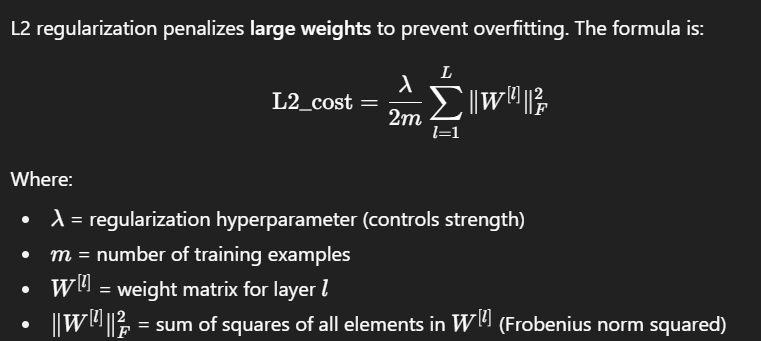

## 1. Non-regularized model

In [76]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
    learning_rate -- learning rate of the optimization
    num_iterations -- number of iterations of the optimization loop
    print_cost -- If True, print the cost every 10000 iterations
    lambd -- regularization hyperparameter, scalar
    keep_prob - probability of keeping a neuron active during drop-out, scalar.
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """
        
    grads = {}
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        #  Correctly handles both dictionary (regularization) and tuple (dropout) caches
        if isinstance(cache, dict):
            cache['W1'] = parameters['W1']
            cache['b1'] = parameters['b1']
            cache['W2'] = parameters['W2']
            cache['b2'] = parameters['b2']
            cache['W3'] = parameters['W3']
            cache['b3'] = parameters['b3']
        # Cost function
        if lambd == 0:
            cost = compute_loss(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # Backward propagation.
        assert(lambd==0 or keep_prob==1)    # it is possible to use both L2 regularization and dropout, 
                                            # but this assignment will only explore one at a time
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache, parameters)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 1.8451439775463963
Cost after iteration 10000: 0.032337610300529555
Cost after iteration 20000: 0.031936126927845566


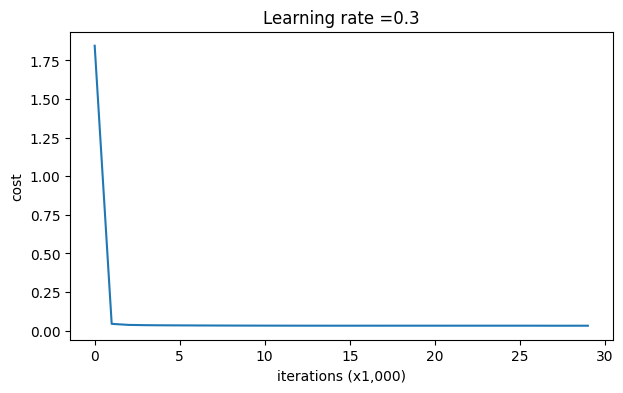

On the training set:
Accuracy: 98.0%
On the test set:
Accuracy: 94.0


In [77]:
parameters = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, parameters)
train_acc = np.mean(predictions_train == train_Y) * 100
print(f"Accuracy: {train_acc}%")
print ("On the test set:")
predictions_test = predict(test_X, parameters)
test_acc = np.mean(predictions_test == test_Y) * 100
print(f"Accuracy: {test_acc}")


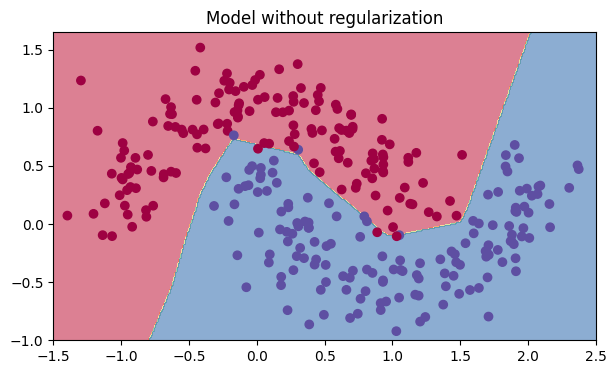

In [78]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-1.5,2.50])
axes.set_ylim([-1.0,1.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x), train_X, train_Y)

## L2- Regularization


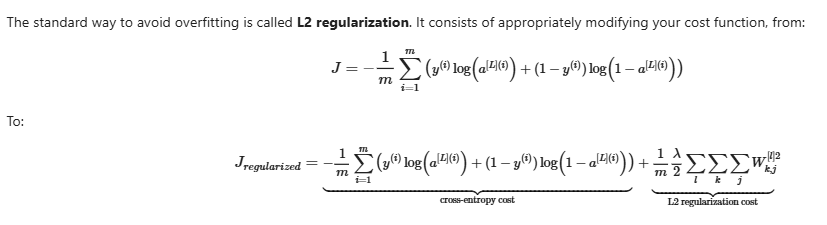

In [79]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]

    cross_entropy_cost = compute_loss(A3, Y)

    L2_reg_cost = 1/m * lambd/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    cost = cross_entropy_cost + L2_reg_cost
    return cost


In [80]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    m = X.shape[1]
    W3 = cache["W3"]
    W2 = cache["W2"]
    W1 = cache["W1"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    A3 = cache["A3"]
    
    dZ3 = A3 - Y
    dW3 = 1/m * np.dot(dZ3, A2.T) + lambd/m * W3 # when differnetiated you will get this
    db3 = 1/m * np.sum(dZ3, axis=1, keepdims=True)

    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1/m * np.dot(dZ2, A1.T) + lambd/m * W2
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    ### START CODE HERE ### (approx. 1 line)
    dW1 = 1./m * np.dot(dZ1, X.T) + lambd/m * W1
    ### END CODE HERE ###
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients


Cost after iteration 0: 1.9038121012771998
Cost after iteration 10000: 0.10048391870991857
Cost after iteration 20000: 0.09991020052660868


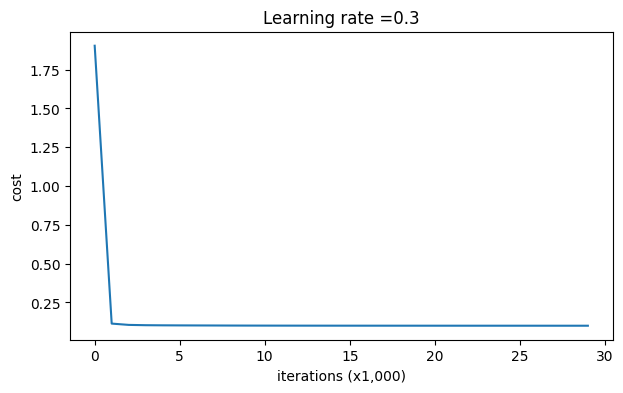

On the training set:
Accuracy: 98.33333333333333%
On the test set:
Accuracy: 95.0


In [81]:
parameters = model(train_X, train_Y, lambd = 0.7)
print ("On the training set:")
predictions_train = predict(train_X, parameters)
train_acc = np.mean(predictions_train == train_Y) * 100
print(f"Accuracy: {train_acc}%")
print ("On the test set:")
predictions_test = predict(test_X, parameters)
test_acc = np.mean(predictions_test == test_Y) * 100
print(f"Accuracy: {test_acc}")

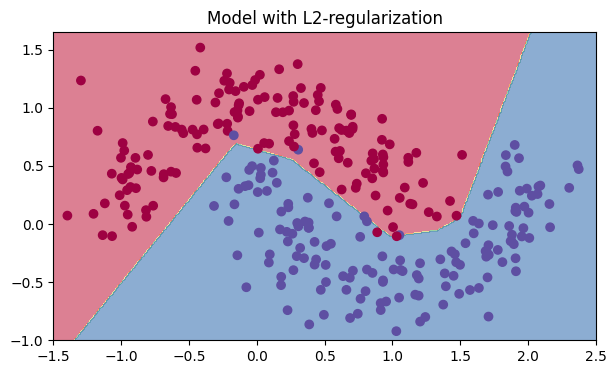

In [82]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-1.5,2.50])
axes.set_ylim([-1.0,1.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x), train_X, train_Y)

## 3. Dropout:

#### 3.1 Forward propagation with dropout

In [83]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    np.random.seed(1)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    
    # Step 1: initialize matrix D1 = np.random.rand(..., ...) < keep_prob
    D1 = np.random.rand(A1.shape[0], A1.shape[1]) < keep_prob
    
    # Step 2: apply dropout to A1, i.e., set A1 to zero wherever D1 is zero
    A1 = A1 * D1
    
    # Step 3: scale the value of neurons that haven't been shut down
    A1 = A1 / keep_prob
    
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    
    # Step 1: initialize matrix D2 = np.random.rand(..., ...) < keep_prob
    D2 = np.random.rand(A2.shape[0], A2.shape[1]) < keep_prob
    
    # Step 2: apply dropout to A2, i.e., set A2 to zero wherever D2 is zero
    A2 = A2 * D2
    
    # Step 3: scale the value of neurons that haven't been shut down
    A2 = A2 / keep_prob
    
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

#### 3.2 Backward propagation with dropout

In [86]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    m = X.shape[1]
    # Corrected: Access tuple elements by index instead of string keys
    W3 = cache[12]
    W2 = cache[9]
    W1 = cache[3]
    A1 = cache[2]
    A2 = cache[7]
    A3 = cache[11]
    D1 = cache[1]
    D2 = cache[6]


    dZ3 = A3 - Y
    dW3 = 1/m * np.dot(dZ3, A2.T)
    db3 = 1/m * np.sum(dZ3, axis=1, keepdims=True)
    dA2 = np.dot(W3.T, dZ3)
    dA2 = dA2 * D2           # Step 1: Apply mask D2 to shut down the same neurons as during the forward propagation
    dA2 = dA2 / keep_prob             # Step 2: Scale the value of neurons that haven't been shut down
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1/m * np.dot(dZ2, A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    dA1 = np.dot(W2.T, dZ2)
    dA1 = dA1 * D1           # Step 1: Apply mask D1 to shut down the same neurons as during the forward propagation
    dA1 = dA1 / keep_prob             # Step 2: Scale the value of neurons that haven't been shut down
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)

    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    return gradients


Cost after iteration 0: 1.9539266039845349
Cost after iteration 10000: 0.23314876752455133
Cost after iteration 20000: 0.4015341296208604


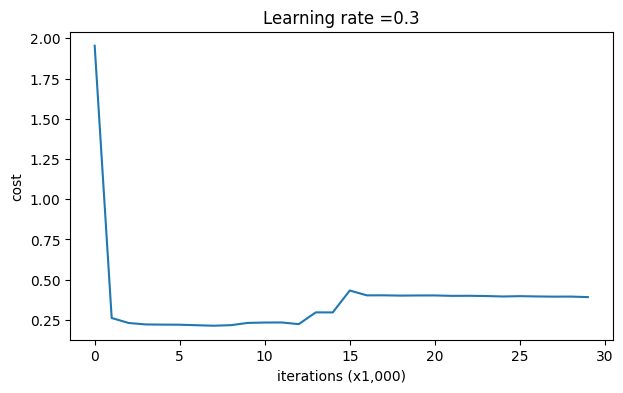

On the train set:
Accuracy: 83.66666666666667%
On the test set:
Accuracy: 84.0


In [87]:
# Run the model with dropout
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)
print ("On the train set:")
predictions_train = predict(train_X, parameters)
train_acc = np.mean(predictions_train == train_Y) * 100
print(f"Accuracy: {train_acc}%")
print ("On the test set:")
predictions_test = predict(test_X, parameters)
test_acc = np.mean(predictions_test == test_Y) * 100
print(f"Accuracy: {test_acc}")

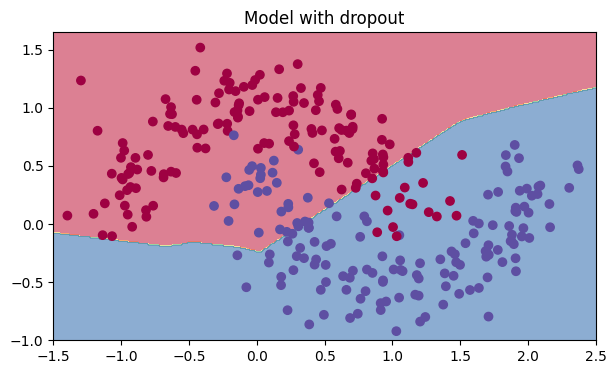

In [88]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-1.5,2.50])
axes.set_ylim([-1.0,1.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x), train_X, train_Y)

## Conclusion:

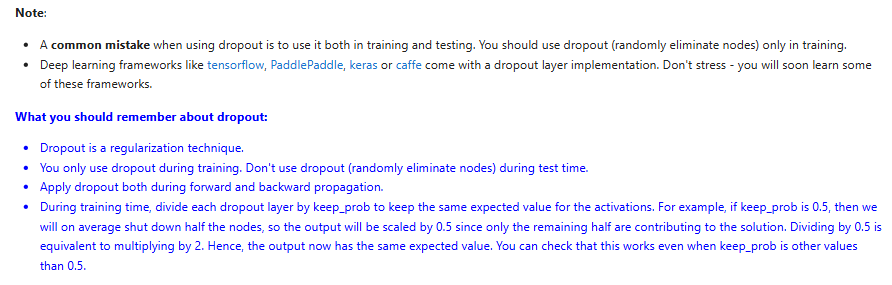